## Titanic Data Analysis

In [37]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%matplotlib inline

In [4]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

<AxesSubplot:>

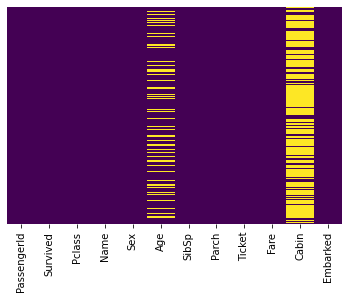

In [7]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<ul><li>The yellow lines show the missing data.</li>
<li>Roughly 20% of the Age data is missing and too much of the Cabin data is also missing.</li></ul>

<AxesSubplot:xlabel='Survived', ylabel='count'>

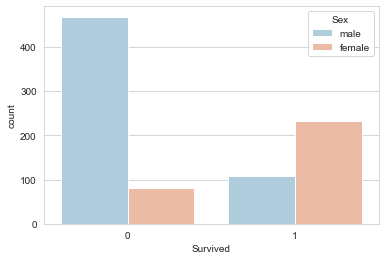

In [14]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,hue='Sex',palette='RdBu_r')

<ul><li>Among the survivers the ratio of female to male is about 2:1.</li></ul>

<AxesSubplot:xlabel='Survived', ylabel='count'>

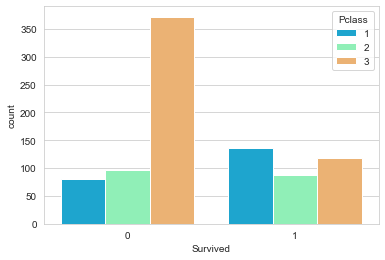

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<ul><li>People who didn't survive were overwhelmingly part of the 3rd class or the lowest class.</li></ul>

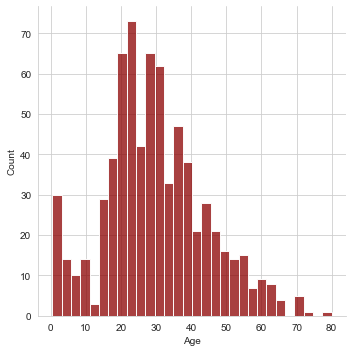

In [16]:
sns.displot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

<ul><li>There were quite a few young passengers onboard.</li>
<li>The average age was around 20-30 on the ship.</li>
<li>The % of people decreased with increasing age.</li></ul>

<AxesSubplot:xlabel='SibSp', ylabel='count'>

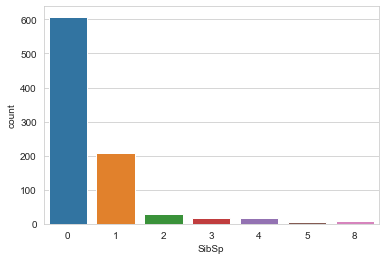

In [17]:
sns.countplot(x='SibSp',data=train)

<ul><li>Most people onboard neither had a children nor a spouse onboard.</li>
</ul>

In [20]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

<ul><li>Most of the ticket purchase price were between 0-50 (cheaper side) as most of the passengers opted for 3rd class tickets.</li>
</ul>

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can check the average age by passenger class.

In [26]:
train[['Pclass', 'Age']].pivot(columns='Pclass', values='Age').iplot(x='Pclass',kind='box')

<ul><li>We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.</li>
<li>We can see from the cufflink plot that the average age of Class 1, Class 2 and Class 3 passengers are 37,29 and 24 respectively.</li></ul>

In [27]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [28]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

<AxesSubplot:>

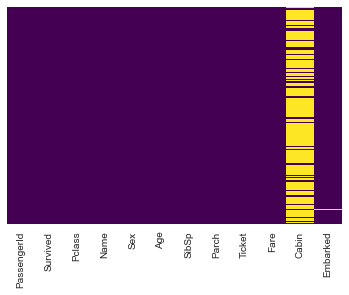

In [29]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<ul><li>We can see that we have got all the age values for all passengers.</li>
<li>We will drop the Cabin column and the row in Embarked that is NaN.</li></ul>

In [30]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Converting Categorical Feature

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [33]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [34]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [35]:
train = pd.concat([train,sex,embark],axis=1)

In [36]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


## Building a Logistic Regression model

In [38]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [42]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [43]:
predictions = logmodel.predict(X_test)

## Evaluation

In [44]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.81      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267

